In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pygus import Species, latlng_array_to_xy

In [2]:
import os
import math
import random
import logging
import pandas as pd
import numpy as np
from typing import Union
from pkg_resources import resource_filename

from shapely.geometry import Polygon, MultiPolygon, Point



def tree_population_from_geojson(
    geojson: Union[Polygon, MultiPolygon],
    num_trees,
    allometrics = None,
    dbh_range=[10, 15], # cm)
    species={"Deciduous": 0.8, "Conifers": 0.2}, # % conifers
    condition_weights=[0.6, 0.3, 0.1, 0.0, 0.0], # excellent, good, fair, critical, dying
) -> pd.DataFrame:
    """This function generates a population of trees, with possibility for modifying the ranges of
    the different parameters. The trees are randomly distributed in a square of side length equal
    to the square root of the area in m2. The trees are assigned a species, a condition, a dbh, a
    height and a crown width.

    Args:
        geojson (dict): A geojson dictionary containing the coordinates of the area where the trees will be generated.
        num_trees (int): The number of trees to generate.

    Returns:
        pd.DataFrame: Returns a tree population which can be used as input for the model.
    """
    df = pd.DataFrame()
    _generate_locations_in_geojson(df, geojson, num_trees)

    #TODO: What do we do with this now?
    if allometrics is None:
        allometrics = Species(resource_filename("pygus", "gus/inputs/allometrics.json"))

    evergreen_pc = _get_evergreen_percentage(species, allometrics)

    return generate_population_features(
        df, allometrics, dbh_range, species, condition_weights
    )


# Ideally, this function could take a dataframe, and add any missing elements needed for the simulation
# id, dbh, height, crownW, species, condition, xpos, ypos, lat, lng
def generate_population_features(
    df: pd.DataFrame,
    allometrics: Species,
    dbh_range=[10, 15],
    species={"Deciduous": 0.8, "Conifers": 0.2}, # % conifers
    condition_weights=[0.6, 0.3, 0.1, 0.0, 0.0],
) -> pd.DataFrame:
    """This function generates a population of trees, with possibility for modifying the ranges of
    the different parameters. The trees are randomly distributed in a square of side length equal
    to the square root of the area in m2. The trees are assigned a species, a condition, a dbh, a
    height and a crown width.

    Args:
        df (pd.DataFrame): _description_
        location (_type_): _description_
        area_m2 (_type_): _description_
        dbh_range (list, optional): _description_. Defaults to [10, 15].
        conifer_percentage (float, optional): _description_. Defaults to 0.2.
        condition_weights (list, optional): _description_. Defaults to [0.6, 0.3, 0.1, 0.0, 0.0].

    Returns:
        pd.DataFrame: Returns a tree population which can be used as input for the model.
    """
    ### id,lat,lng

    ## id,lat,lng,xpos,ypos
    if "xpos" not in df.columns or "ypos" not in df.columns:
        latlng_array_to_xy(df, "lat", "lng")
    
    ## id,lat,lng,xpos,ypos,dbh
    if "dbh" not in df.columns:
        df["dbh"] = np.around(np.random.uniform(*dbh_range, len(df)), 3)
        print(df["dbh"].mean())
        if df["dbh"].mean() < 2:
            SAPLING_HEIGHT = [0.3, 0.5]
            df["height"] = np.around(np.random.uniform(*SAPLING_HEIGHT, len(df)), 3)

    ## id,lat,lng,xpos,ypos,dbh,species
    if "species" not in df.columns:
        s = list(species.keys())
        # species is a dict of str to float
        df["species"] = random.choices(
            s, weights=list(species.values()),
            k=len(df),
        )

    if "height" not in df.columns:
        all_species = list(species.keys())
        equations = {}
        for s in all_species:
            equations[s] = allometrics.get_eqn(allometrics.fuzzymatch(s), "height")
        print(equations)
        df["height"] = df.apply(lambda row: equations[row["species"]](row["dbh"]), axis=1)

    ## id,lat,lng,xpos,ypos,dbh,species,condition
    if "condition" not in df.columns:
        df["condition"] = random.choices(
            ["excellent", "good", "fair", "critical", "dying"],
            weights=condition_weights,
            k=len(df),
        )

    if "id" not in df.columns:
        df.index.name = 'id'
        df.reset_index(inplace=True)

    column_out_order = ["id", "species", "dbh", "lat", "lng", "condition", "xpos", "ypos"]
    df.reindex(columns=column_out_order)
    return df
        
def _generate_locations_in_geojson(df, polygon: Union[Polygon, MultiPolygon], num_points):
    if polygon.geom_type == "Polygon":
        min_x, min_y, max_x, max_y = polygon.bounds
    elif polygon.geom_type == "MultiPolygon":
        min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    while len(points) < num_points:
        random_point = Point(
            [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        )
        if polygon.contains(random_point):
            points.append(random_point)

    df["lat"] = [point.y for point in points]
    df["lng"] = [point.x for point in points]

def _get_evergreen_percentage(species_dict, allometrics: Species):
    # check species_dict values total 1
    if not sum(species_dict.values()) - 1.0 < 1e-6:
        raise ValueError(f"Species dictionary values must sum to 1, got {sum(species_dict.values())}")
    
    evergreens = 0
    for species in species_dict:
        fuzzy = allometrics.fuzzymatch(species)
        if fuzzy is not None:
            if allometrics.is_evergreen(fuzzy):
                print(f"{species} is evergreen ({species_dict[species] * 100:.2f}%)")
                evergreens += species_dict[species]
        else:
            print(f"Species {species} not found in allometrics.json")

    logging.debug(f"Evergreen percentage: {evergreens * 100:.2f}%")
    return evergreens


def _generate_locations_in_square_area(
    df: pd.DataFrame, initial_coordinates, area_m2: float
) -> pd.DataFrame:
    lat = initial_coordinates[0]
    lng = initial_coordinates[1]
    half_side_length = np.sqrt(area_m2) / 2
    R = 6371e3  # Earth radius in metres

    bottom_left = [
        lat - (half_side_length / R) * (180 / math.pi),
        lng - (half_side_length / R) * (180 / math.pi) / math.cos(lat * math.pi / 180),
    ]
    top_right = [
        lat + (half_side_length / R) * (180 / math.pi),
        lng + (half_side_length / R) * (180 / math.pi) / math.cos(lat * math.pi / 180),
    ]
    bbox = [*bottom_left, *top_right]

    # for each element of the dataframe, assign a random lat and lng
    for i in range(len(df)):
        lat = np.random.uniform(bbox[1], bbox[3])
        lng = np.random.uniform(bbox[0], bbox[2])
        df.loc[i, "lat"] = lat
        df.loc[i, "lng"] = lng

def _bounding_box_to_geojson(bbox):
    min_lat, min_lon, max_lat, max_lon = bbox
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [min_lon, min_lat],
                [min_lon, max_lat],
                [max_lon, max_lat],
                [max_lon, min_lat],
                [min_lon, min_lat],
            ]
        ],
    }

In [3]:
species_dist = {
  "Acer campestre": 0.05,
  "Betula pendula": 0.05,
  "Betula pubescens": 0.05,
  "Carpinus betulus": 0.05,
  "Cornus sanguinea": 0.07,
  "Corylus avellana": 0.1,
  "Euonymus europaeus": 0.05,
  "Malus sylvestris": 0.05,
  "Prunus avium": 0.05,
  "Prunus spinosa": 0.05,
  "Quercus petraea": 0.02,
  "Quercus robur": 0.02,
  "Rosa canina": 0.05,
  "Salix caprea": 0.05,
  "Salix cinerea": 0.05,
  "Sambucus nigra": 0.07,
  "Sorbus aria": 0.05,
  "Sorbus torminalis": 0.05,
  "Tilia cordata": 0.02,
  "Viburnum opulus": 0.05
}

species = species_dist.keys()
ratios = species_dist.values()

In [4]:
sites = [
    {"name": "Forest of Thanks", "trees": 30000, "lat": 51.546514, "lng": 0.126283, "shape": "input/forest_of_thanks.geojson"},
    {"name": "Castle Green Forest", "trees": 1400, "lat": 51.532997, "lng": 0.119295, "shape": "input/castle_green_forest.geojson"},
    {"name": "Thames View Junior", "trees": 1200, "lat": 51.526769, "lng": 0.102509, "shape": "input/thames_view_junior.geojson"},
]

In [5]:
from shapely import from_geojson
from pkg_resources import resource_filename
allometrics_path = resource_filename("pygus", "gus/inputs/allometrics_extended.json")
species_allometrics = Species(allometrics_path)
species_map = {}
# check how many are in our allometrics file, and highlight ones that are not
for s in species:
    species_map[s] = species_allometrics.fuzzymatch(s)

print(species_map)

{'Acer campestre': 'acer campestre', 'Betula pendula': 'betula pendula', 'Betula pubescens': 'betula pubescens', 'Carpinus betulus': 'carpinus betulus', 'Cornus sanguinea': 'cornus sanguinea', 'Corylus avellana': 'corylus avellana', 'Euonymus europaeus': 'fraxinus excelsior', 'Malus sylvestris': 'malus sylvestris', 'Prunus avium': 'prunus avium', 'Prunus spinosa': 'prunus spinosa', 'Quercus petraea': 'quercus petraea', 'Quercus robur': 'quercus robur', 'Rosa canina': 'decidu', 'Salix caprea': 'salix caprea', 'Salix cinerea': 'salix cinerea', 'Sambucus nigra': 'quercus nigra', 'Sorbus aria': 'sorbus aria', 'Sorbus torminalis': 'sorbus torminalis', 'Tilia cordata': 'tilia cordata', 'Viburnum opulus': 'decidu'}


In [6]:
for site in sites:
    # for each site, generate a population, load the geojson
    shapely_geojson = from_geojson(open(site["shape"]).read())
    print(shapely_geojson)


    # generate population within each geojson
    site_df = tree_population_from_geojson(
        shapely_geojson, 
        site["trees"], 
        allometrics=species_allometrics,
        species=species_dist,
        dbh_range=[0.5, 1.5],
        condition_weights=[0.8, 0.2, 0.0, 0.0, 0.0]
    )
    site["df"] = site_df
    
    site_df.to_csv(f"output/{site['name']}.csv", index=False)

    print(site_df["dbh"].describe())
    print(site_df["height"].describe())
    # print the top 5 rows sorted by height
    print(site_df.sort_values("height", ascending=False).head(5))


# trees_CGf = from_geojson(open(sites[1]["shape"]).read())
# trees_TVj = from_geojson(open(sites[2]["shape"]).read())
    


MULTIPOLYGON (((0.1273308912034281 51.5468999931085, 0.1271949353328807 51.546920017465595, 0.1270589794849286 51.54694004182977, 0.1269337569938784 51.546944491689885, 0.1268228456405041 51.54692891717414, 0.1267927184590292 51.54692446731397, 0.1267198891399346 51.54690925097901, 0.1266089777905961 51.5468736520688, 0.1265231109452998 51.54683137833294, 0.1264730219491241 51.54680022924006, 0.1264229329518969 51.54675350556042, 0.1265231109452998 51.54673125617239, 0.1265875110993875 51.546706781814464, 0.1266698001644784 51.54666673286658, 0.1267342003114891 51.54663558364385, 0.126784636621629 51.54660633642547, 0.1268493840722584 51.54664828743128, 0.1269717234042957 51.546705490070536, 0.1271566739812329 51.54682387846472, 0.1273308912034281 51.5468999931085)), ((0.1270965669326927 51.546583257401835, 0.1272074782831112 51.546545433296075, 0.1272647228496453 51.54650760915803, 0.1273112340611533 51.54645643527161, 0.1273505897013365 51.546403036373135, 0.1275402123312119 51.54644

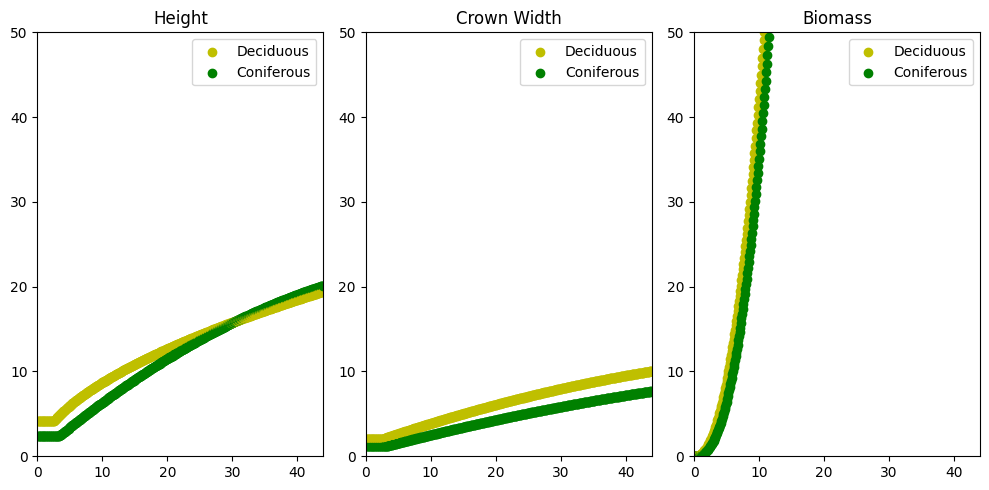

In [7]:
import matplotlib.pyplot as plt
import numpy as np

h_decidu = species_allometrics.get_eqn("decidu", "height")
h_conif = species_allometrics.get_eqn("conifer", "height")

biomass_decidu = species_allometrics.get_eqn_biomass("decidu")
biomass_conif = species_allometrics.get_eqn_biomass("conifer")

crownWidth_decidu = species_allometrics.get_eqn("decidu", "crown_width")
crownWidth_conif = species_allometrics.get_eqn("conifer", "crown_width")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # Create figure and subplots outside the loop

# Set titles
axs[0].set_title("Height")
axs[1].set_title("Crown Width")
axs[2].set_title("Biomass")

# Set x and y limits
for ax in axs:
    ax.set_xlim(0, 44)
    ax.set_ylim(0, 50)

# Plot data
for i in np.arange(0.1, 44, 0.1):
    axs[0].scatter(i, h_decidu(i), color='y')  # Plot height for deciduous
    axs[0].scatter(i, h_conif(i), color='g')  # Plot height for coniferous
    axs[1].scatter(i, crownWidth_decidu(i), color='y')  # Plot crown width for deciduous
    axs[1].scatter(i, crownWidth_conif(i), color='g')  # Plot crown width for coniferous
    axs[2].scatter(i, biomass_decidu(i), color='y')  # Plot biomass for deciduous
    axs[2].scatter(i, biomass_conif(i), color='g')  # Plot biomass for conifer

# Set legends
axs[0].legend(["Deciduous", "Coniferous"])
axs[1].legend(["Deciduous", "Coniferous"])
axs[2].legend(["Deciduous", "Coniferous"])

plt.tight_layout()
plt.show()

In [8]:
# Below I'll plot the distributions of: DBH, height, and lat/lng
def plot_dbh_height_and_latlng(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("DBH, Height, and Lat/Lng Distributions")
    axs[0].hist(df["dbh"], bins=20)
    axs[0].set_title("DBH Distribution")
    axs[1].hist(df["height"], bins=20)
    axs[1].set_title("Height Distribution")
    axs[2].scatter(df["lat"], df["lng"])
    axs[2].set_title("Tree Locations")
    plt.show()

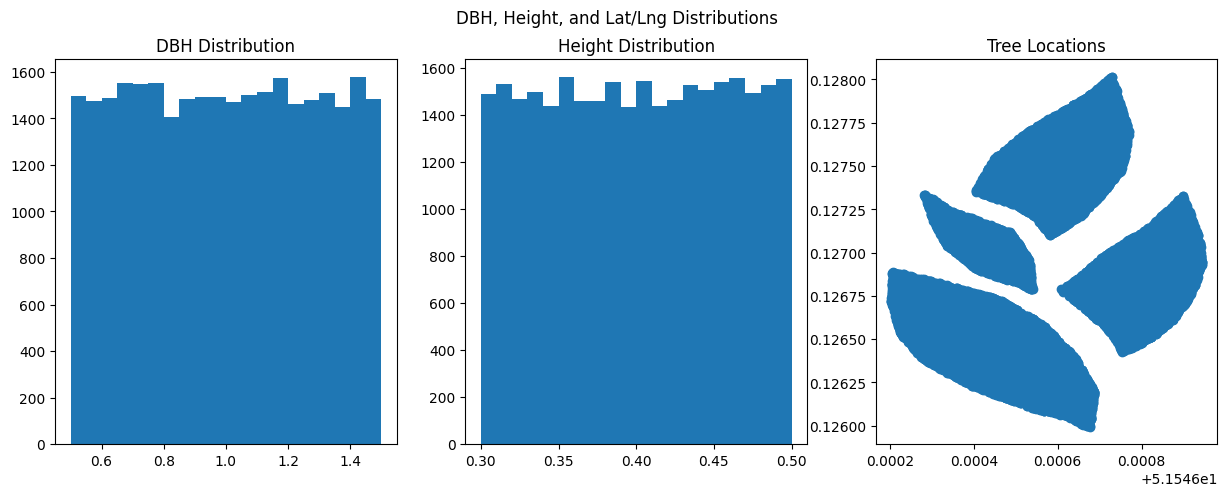

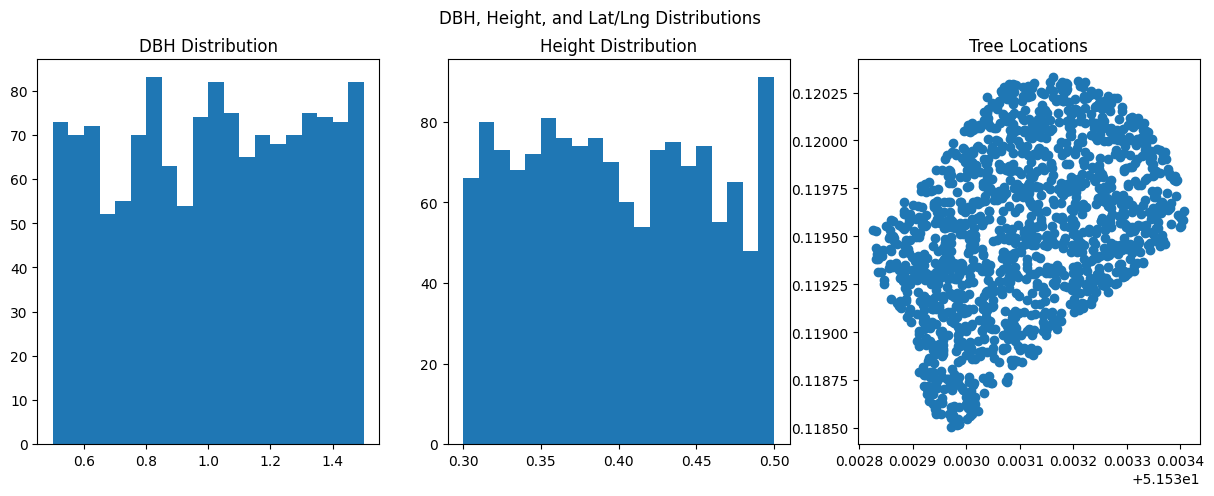

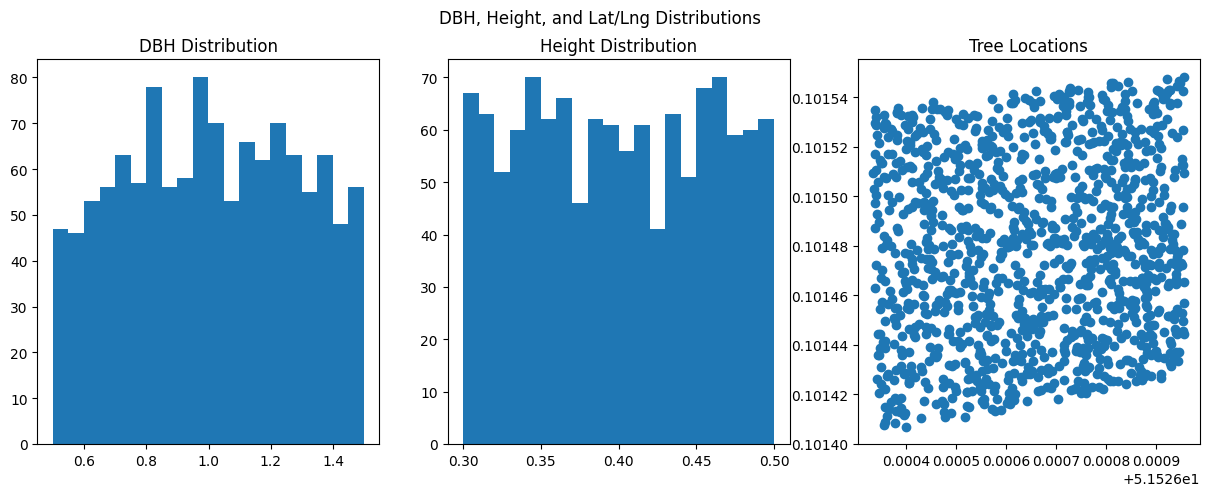

In [9]:
for site in sites:
    df = pd.read_csv(f"output/{site['name']}.csv")
    plot_dbh_height_and_latlng(df)

In [36]:
# TODO
from pygus import Miyawaki, Urban, SiteConfig, ScenarioConfig, WeatherConfig

df_thanks = sites[0]["df"]
df_castle = sites[1]["df"]
df_thames = sites[2]["df"]

In [32]:
df_thanks.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.546906,0.126878,62,78,0.594,0.482,Prunus spinosa,good
1,1,51.546565,0.126397,27,42,0.875,0.475,Corylus avellana,good
2,2,51.546466,0.126393,26,31,0.745,0.427,Corylus avellana,excellent
3,3,51.546453,0.126914,62,28,0.720,0.346,Cornus sanguinea,excellent
4,4,51.546459,0.126311,21,30,1.475,0.401,Malus sylvestris,good


In [33]:
df_castle.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.532946,0.118709,13,15,1.186,0.361,Euonymus europaeus,excellent
1,1,51.533048,0.120195,117,23,1.038,0.343,Prunus spinosa,excellent
2,2,51.532887,0.119479,67,7,0.728,0.367,Cornus sanguinea,excellent
3,3,51.533102,0.118985,33,32,1.015,0.441,Corylus avellana,excellent
4,4,51.533039,0.119884,95,22,1.308,0.394,Corylus avellana,excellent


In [34]:
df_thames.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.526764,0.101442,4,47,1.063,0.374,Salix caprea,excellent
1,1,51.526410,0.101481,5,8,0.776,0.444,Quercus petraea,good
2,2,51.526736,0.101422,2,44,1.228,0.346,Viburnum opulus,excellent
3,3,51.526719,0.101522,9,42,1.083,0.475,Prunus avium,excellent
4,4,51.526378,0.101477,5,4,0.688,0.373,Acer campestre,good


In [39]:
site_config_a = SiteConfig(
    total_m2=100,
    impervious_m2=0,
    pervious_m2=100,
    weather=WeatherConfig(
        growth_season_mean=155,
        growth_season_var=7,
    ),
    tree_density_per_ha=5,
    project_site_type="park",
    light_loss_multiplier = 0
)

site_config_b = SiteConfig(
    total_m2=1000,
    impervious_m2=0,
    pervious_m2=1000,
    weather=WeatherConfig(
        growth_season_mean=155,
        growth_season_var=7,
    ),
    tree_density_per_ha=5,
    project_site_type="park",
    light_loss_multiplier = 0.75
)

# SCENARIO
scenario_config = ScenarioConfig(
    1,
    is_crownsunexposure_fixed=1,
    time_horizon_years=50,
)

In [40]:

#Initialise the model environment
urban = Miyawaki(
    population=df_thames,
    species_allometrics=species_allometrics,
    site_config=site_config_a,
    scenario=scenario_config,
)
df_urban = urban.run()


In [41]:

miyawaki = Miyawaki(
    population=df_castle,
    species_allometrics=species_allometrics,
    site_config=site_config_a,
    scenario=scenario_config,
)
df_miyawaki = miyawaki.run()

In [42]:
df_miyawaki.tail()

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std,Cum_Seq
45,145942.617877,4208.574467,3.418826,2269.655638,1.810956,1231,169,0,0,0,3834,3.035430,145268.712654
46,150078.992004,4126.968479,3.391100,1915.774604,1.678394,1217,183,0,0,0,3912,2.985260,149395.681133
47,154191.534859,4102.426556,3.365403,2790.342385,2.204432,1219,181,0,0,0,3999,2.960652,153498.107689
48,158016.440829,3812.812607,3.156302,2691.192415,2.339261,1208,192,0,0,0,4083,2.796920,157310.920296
49,161795.791983,3766.481137,3.125710,2254.669210,1.795783,1205,195,0,0,0,4176,2.783178,161077.401434


In [43]:
df_urban.tail()

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std,Cum_Seq
45,16508.091862,231.361476,0.224623,291.792332,0.277558,1030,170,0,0,0,3640,0.521913,15880.549027
46,16741.524254,223.169427,0.215623,80.919621,0.067731,1035,165,0,0,0,3715,0.498388,16103.718454
47,16978.585504,226.033847,0.217549,80.973635,0.086072,1039,161,0,0,0,3796,0.520940,16329.752301
48,17213.154054,222.844540,0.215309,318.822211,0.335306,1035,165,0,0,0,3886,0.557995,16552.596841
49,17436.178747,212.175573,0.205199,115.713683,0.087792,1034,166,0,0,0,3968,0.538864,16764.772414


<Axes: >

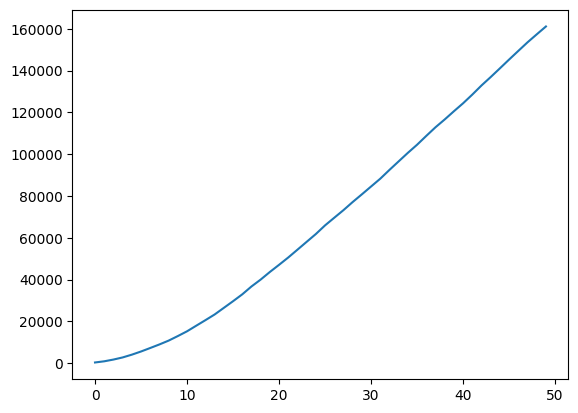

In [44]:
df_miyawaki.Cum_Seq.plot()

<Axes: >

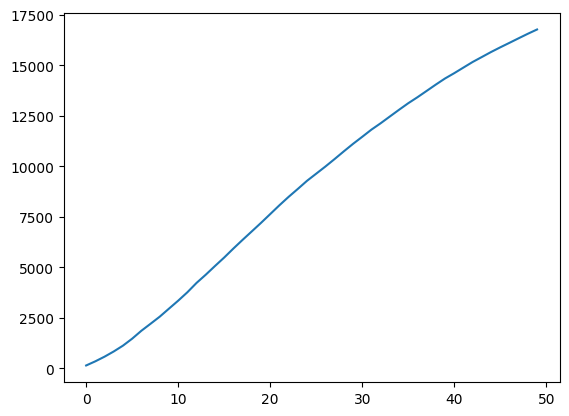

In [45]:
df_urban.Cum_Seq.plot()

In [17]:
agents_df = urban.get_agent_data()
agents_df.reset_index(inplace=True)
agents_df.head(20)

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
0,1,0,fraxinus excelsior,2.062490,4.526933,2.303374,0.949772,0.000000,1.000000,excellent,...,0.360479,0.000000,0.0,0.000114,0.000000,13,15,2,51.532946,0.118709
1,1,1,prunus spinosa,1.821483,4.283814,2.303374,2.023323,0.289950,0.891269,excellent,...,0.456361,0.000000,0.0,0.000077,0.000000,117,23,2,51.533048,0.120195
2,1,2,cornus sanguinea,1.513297,4.283814,2.303374,2.023323,0.289950,0.890300,excellent,...,0.300721,0.000000,0.0,0.000000,0.000000,67,7,2,51.532887,0.119479
3,1,3,corylus avellana,1.845848,4.283814,2.303374,2.023323,0.144975,0.945634,excellent,...,0.470213,0.000000,0.0,0.000092,0.000000,33,32,2,51.533102,0.118985
4,1,4,corylus avellana,2.135605,4.283814,2.303374,2.023323,0.144975,0.944666,excellent,...,0.652815,0.000000,0.0,0.000221,0.000000,95,22,2,51.533039,0.119884
5,1,5,cornus sanguinea,1.836775,4.283814,2.303374,2.023323,0.144975,0.945634,good,...,0.465028,0.000000,0.0,0.000818,0.000000,69,36,2,51.533148,0.119498
6,1,6,cornus sanguinea,2.376892,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,0.830614,0.000000,0.0,0.000008,0.000000,27,14,2,51.532938,0.118907
7,1,7,malus sylvestris,2.028838,4.283814,2.303374,2.023323,0.289950,0.891269,good,...,0.581660,0.000000,0.0,0.002120,0.000000,91,47,2,51.533255,0.119811
8,1,8,salix caprea,1.507986,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,0.298352,0.000000,0.0,0.000035,0.000000,103,39,2,51.533186,0.119985
9,1,9,acer campestre,1.317908,4.283814,2.303374,2.023323,0.434924,0.834966,excellent,...,0.220324,0.000000,0.0,0.000024,0.000000,8,15,2,51.532938,0.118624


In [18]:
agents_df.tail(200)

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
174219,50,5340,tilia cordata,1.915683,4.433814,2.303374,2.023323,1.000000,0.326377,excellent,...,0.511193,0.0,0.0,0.000000,0.0,81,32,3,51.533123,0.119667
174220,50,5341,corylus avellana,2.441907,4.433814,2.303374,2.023323,0.646650,0.679869,excellent,...,0.882614,0.0,0.0,0.000002,0.0,56,8,3,51.532898,0.119324
174221,50,5342,cornus sanguinea,1.748586,4.433814,2.303374,2.023323,0.000000,1.000000,excellent,...,0.416288,0.0,0.0,0.000000,0.0,52,45,3,51.533223,0.119245
174222,50,5343,decidu,2.670975,4.433814,2.343786,2.057469,0.699322,0.686002,excellent,...,1.079931,0.0,0.0,0.000268,0.0,85,50,3,51.533279,0.119717
174223,50,5344,carpinus betulus,2.326477,4.433814,2.303374,2.023323,0.646838,0.734744,excellent,...,0.791494,0.0,0.0,0.000007,0.0,98,59,3,51.533366,0.119900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174414,50,5535,betula pendula,0.556651,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,0.031681,0.0,0.0,0.000000,0.0,64,42,1,51.533206,0.119418
174415,50,5536,salix caprea,1.338040,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,0.227970,0.0,0.0,0.000000,0.0,101,59,1,51.533371,0.119940
174416,50,5537,betula pubescens,0.997718,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,0.117778,0.0,0.0,0.000000,0.0,74,3,1,51.532859,0.119584
174417,50,5538,acer campestre,1.080738,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,0.140985,0.0,0.0,0.000000,0.0,63,15,1,51.532962,0.119428


In [19]:
agents_df[["AgentID", "dbh", "height", "biomass", "condition", "carbon"]].tail(200)

,AgentID,dbh,height,biomass,condition,carbon
174219,5340,1.915683,4.433814,1.022387,excellent,0.511193
174220,5341,2.441907,4.433814,1.765229,excellent,0.882614
174221,5342,1.748586,4.433814,0.832577,excellent,0.416288
174222,5343,2.670975,4.433814,2.159861,excellent,1.079931
174223,5344,2.326477,4.433814,1.582989,excellent,0.791494
...,...,...,...,...,...,...
174414,5535,0.556651,4.133814,0.063362,excellent,0.031681
174415,5536,1.338040,4.133814,0.455940,excellent,0.227970
174416,5537,0.997718,4.133814,0.235555,excellent,0.117778
174417,5538,1.080738,4.133814,0.281970,excellent,0.140985


In [20]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step50.head()

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
168948,50,69,sorbus torminalis,39.757696,18.418357,10.604787,9.482863,0.454699,0.896137,excellent,...,470.267103,0.0,0.0,0.000000,0.047027,88,39,51,51.533189,0.119771
168962,50,83,sorbus torminalis,38.986682,18.223467,10.497599,9.373998,0.797249,0.872600,excellent,...,449.993909,0.0,0.0,0.067499,0.000000,99,32,51,51.533126,0.119929
168964,50,85,quercus nigra,36.325345,17.452849,11.866056,9.506959,0.493300,0.866618,excellent,...,383.804607,0.0,0.0,0.087381,0.000000,26,15,51,51.532948,0.118896
168979,50,100,prunus spinosa,8.443861,7.938572,4.046457,3.507088,1.000000,0.667921,excellent,...,14.395152,0.0,0.0,0.001440,0.000000,80,21,51,51.533022,0.119669
169003,50,124,corylus avellana,25.923597,14.600393,8.264901,7.235832,0.000000,1.000000,excellent,...,179.647163,0.0,0.0,0.041920,0.000000,99,19,51,51.533012,0.119936


In [21]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step20 = not_dead[not_dead["Step"] == 10]

# find the overlapping agents between step 20 and step 50

intersection = step20.merge(step50, on=["AgentID"], how="inner")
intersection.tail(10)



,Step_x,AgentID,species_x,dbh_x,height_x,crownH_x,crownW_x,canopy_overlap_x,cle_x,condition_x,...,carbon_y,deroot_y,detrunk_y,mulched_y,burnt_y,xpos_y,ypos_y,est_age_y,lat_y,lng_y
100,10,2098,tilia cordata,2.085692,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,390.541751,0.0,0.0,0.139065,0.000000,33,28,42,51.533069,0.118984
101,10,2103,corylus avellana,1.484954,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,161.351279,0.0,0.0,0.451045,0.000000,74,42,42,51.533202,0.119563
102,10,2113,sorbus torminalis,1.974413,4.283814,2.303374,2.023323,0.646485,0.690179,excellent,...,133.606547,0.0,0.0,0.035375,0.000000,70,32,42,51.533112,0.119515
103,10,2122,decidu,1.929649,4.283814,2.303374,2.023323,0.567374,0.734193,excellent,...,371.064565,0.0,0.0,0.130489,0.000000,91,32,42,51.533119,0.119817
104,10,2139,corylus avellana,1.437679,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,155.034917,0.0,0.0,0.000000,0.015503,74,63,41,51.533398,0.119549
105,10,2150,cornus sanguinea,1.033597,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,83.803826,0.0,0.0,0.191207,0.000000,108,23,41,51.533044,0.120072
106,10,2172,sorbus aria,0.880281,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,198.309956,0.0,0.0,0.070306,0.000000,29,15,41,51.532949,0.118936
107,10,2173,cornus sanguinea,1.074244,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,83.693867,0.0,0.0,0.004185,0.000000,20,18,41,51.532973,0.118808
108,10,2201,malus sylvestris,1.394056,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,89.580517,0.0,0.0,0.017916,0.000000,101,26,41,51.533069,0.119971
109,10,2212,salix cinerea,1.257801,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,87.528060,0.0,0.0,0.134425,0.000000,116,47,41,51.533267,0.120168


In [22]:
# agent 51
agents_df[agents_df["AgentID"] == 1990]

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
13560,8,1990,salix cinerea,0.673428,4.133814,2.303374,2.023323,0.0,0.56,excellent,...,0.048631,0.000000,0.0,0.000000,0.000000,30,13,1,51.532932,0.118954
15583,9,1990,salix cinerea,1.766285,4.283814,2.303374,2.023323,0.0,1.00,excellent,...,0.425830,0.000000,0.0,0.000201,0.000000,30,13,2,51.532932,0.118954
17707,10,1990,salix cinerea,2.944020,4.433814,2.427781,2.128473,0.0,1.00,excellent,...,1.344358,0.000000,0.0,0.000567,0.000000,30,13,3,51.532932,0.118954
19924,11,1990,salix cinerea,4.034443,4.583814,2.759792,2.409618,0.0,1.00,excellent,...,2.731752,0.000000,0.0,0.001015,0.000000,30,13,4,51.532932,0.118954
22231,12,1990,salix cinerea,5.205409,4.733814,3.110222,2.707225,0.0,1.00,excellent,...,4.847034,0.000000,0.0,0.002043,0.000000,30,13,5,51.532932,0.118954
24629,13,1990,salix cinerea,6.303272,4.883814,3.433032,2.982205,0.0,1.00,excellent,...,7.455805,0.000000,0.0,0.003515,0.000000,30,13,6,51.532932,0.118954
27101,14,1990,salix cinerea,7.388227,5.033814,3.746586,3.250103,0.0,1.00,excellent,...,10.658636,0.000000,0.0,0.000000,0.004492,30,13,7,51.532932,0.118954
29635,15,1990,salix cinerea,8.468777,7.951288,4.053472,3.513110,0.0,1.00,excellent,...,14.490911,0.000000,0.0,0.005382,0.000000,30,13,8,51.532932,0.118954
32249,16,1990,salix cinerea,9.612348,8.517620,4.372393,3.787323,0.0,1.00,excellent,...,19.269818,0.000000,0.0,0.000000,0.008121,30,13,9,51.532932,0.118954
34942,17,1990,salix cinerea,10.581121,8.973686,4.637848,4.016296,0.0,1.00,excellent,...,23.917548,0.000000,0.0,0.008883,0.000000,30,13,10,51.532932,0.118954


# To investigate

height is not factored into the carbon impacts

1. Overlapping ratio
    -> produce an initial population with 0 overlap (each tree in a separate grid cell)
2. Identical population agents
    -> increasing numbers, with the same density
3. Same number of trees, with increasing density


